In [1]:
import random
import math
import csv



In [8]:
file = 'data/c1type_vc200/C101.csv'
capacity = 200
data = []
with open(file, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        data.append(row)

customers = {}
for customer in data:
    customer = {
        'id': int(customer[0]) - 1,
        'x': float(customer[1]),
        'y': float(customer[2]),
        'demand': float(customer[3]),
        'ready_time': float(customer[4]),
        'due_time': float(customer[5]),
        'service_time': float(customer[6])
    }
    customers[int(customer['id'])] = customer

vehicle_capacity = 200
vehicle_speed = 1.0 

In [11]:
def get_distance(c1, c2):
    """Calculate Euclidean distance between two customers."""
    dx = customers[c1]['x'] - customers[c2]['x']
    dy = customers[c1]['y'] - customers[c2]['y']
    return math.sqrt(dx**2 + dy**2)

def get_travel_time(c1, c2, speed):
    return get_distance(c1, c2) / speed

def split_routes(individual, customers, vehicle_capacity, speed):
    """Split permutation into feasible routes considering constraints."""
    routes = []
    current_route = [0]
    current_load = 0
    current_time = 0
    last_customer = 0

    for customer_id in individual:
        customer = customers[customer_id]
        travel_time = get_travel_time(last_customer, customer_id, speed)
        arrival_time = current_time + travel_time
        arrival_time = max(arrival_time, customer['ready_time'])
        time_violation = arrival_time > customer['due_time']
        capacity_violation = (current_load + customer['demand']) > vehicle_capacity

        if time_violation or capacity_violation:
            # Start new route
            current_route.append(0)
            routes.append(current_route)
            current_route = [0]
            current_load = 0
            current_time = 0
            last_customer = 0
            # Recalculate for new route
            travel_time = get_travel_time(0, customer_id, speed)
            arrival_time = travel_time
            arrival_time = max(arrival_time, customer['ready_time'])
            time_violation = arrival_time > customer['due_time']
            capacity_violation = customer['demand'] > vehicle_capacity
            if time_violation or capacity_violation:
                pass  # Penalty applied in fitness

        # Update route details
        current_route.append(customer_id)
        current_load += customer['demand']
        current_time = arrival_time + customer['service_time']
        last_customer = customer_id

    # Finalize the last route
    current_route.append(0)
    routes.append(current_route)
    return routes

def evaluate_fitness(individual, customers, vehicle_capacity, speed):
    """Calculate fitness based on vehicles, distance, and violations."""
    routes = split_routes(individual, customers, vehicle_capacity, speed)
    num_vehicles = len(routes)
    total_distance = 0
    time_violations = 0
    capacity_violations = 0

    for route in routes:
        # Check capacity
        route_demand = sum(customers[c]['demand'] for c in route if c != 0)
        if route_demand > vehicle_capacity:
            capacity_violations += (route_demand - vehicle_capacity)
        # Check time windows and calculate distance
        current_time = 0
        last_customer = 0
        route_distance = 0
        for c in route[1:]:  # Skip starting depot
            if c == 0:
                continue  # Skip ending depot for customer checks
            # Time check
            travel_time = get_travel_time(last_customer, c, speed)
            arrival_time = current_time + travel_time
            arrival_time = max(arrival_time, customers[c]['ready_time'])
            if arrival_time > customers[c]['due_time']:
                time_violations += (arrival_time - customers[c]['due_time'])
            current_time = arrival_time + customers[c]['service_time']
            last_customer = c
        # Calculate route distance
        for i in range(len(route)-1):
            route_distance += get_distance(route[i], route[i+1])
        total_distance += route_distance

    # Weighted sum fitness (adjust weights as needed)
    fitness = (num_vehicles * 1000) + (total_distance * 1) + (time_violations * 100) + (capacity_violations * 100)
    return fitness

def generate_individual(customers):
    """Generate a random permutation of customers (excluding depot)."""
    customer_ids = [c for c in customers if c != 0]
    random.shuffle(customer_ids)
    return customer_ids

def tournament_selection(population, fitnesses, tournament_size):
    """Select parents using tournament selection."""
    selected = []
    for _ in range(2):
        contestants = random.sample(list(zip(population, fitnesses)), tournament_size)
        contestants.sort(key=lambda x: x[1])  # Lower fitness is better
        selected.append(contestants[0][0])
    return selected[0], selected[1]

def ox_crossover(parent1, parent2):
    """Ordered crossover (OX) for permutations."""
    size = len(parent1)
    start, end = sorted(random.sample(range(size), 2))
    child = [None] * size
    child[start:end+1] = parent1[start:end+1]
    ptr = 0
    for i in range(size):
        if child[i] is None:
            while parent2[ptr] in child:
                ptr += 1
            child[i] = parent2[ptr]
            ptr += 1
    return child

def mutate(individual, mutation_rate):
    """Swap two customers with mutation probability."""
    if random.random() < mutation_rate:
        i, j = random.sample(range(len(individual)), 2)
        individual[i], individual[j] = individual[j], individual[i]
    return individual

def genetic_algorithm(customers, vehicle_capacity, speed, population_size=50, generations=100, tournament_size=5, mutation_rate=0.1):
    """Main GA loop for VRPTW."""
    population = [generate_individual(customers) for _ in range(population_size)]
    best_fitness = float('inf')
    best_individual = None

    for gen in range(generations):
        fitnesses = [evaluate_fitness(ind, customers, vehicle_capacity, speed) for ind in population]
        current_best = min(fitnesses)
        if current_best < best_fitness:
            best_fitness = current_best
            best_individual = population[fitnesses.index(current_best)]
        
        offspring = []
        for _ in range(population_size // 2):
            parent1, parent2 = tournament_selection(population, fitnesses, tournament_size)
            child1 = ox_crossover(parent1, parent2)
            child2 = ox_crossover(parent2, parent1)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            offspring.extend([child1, child2])
        
        # Elitism: keep best individual
        if best_individual is not None:
            offspring[0] = best_individual
        population = offspring[:population_size]
        
        print(f"Generation {gen+1}, Best Fitness: {best_fitness}")

    return best_individual, best_fitness

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_routes(solution, customers, vehicle_capacity, speed):
    """Plot the routes of the best solution."""
    routes = split_routes(solution, customers, vehicle_capacity, speed)
    plt.figure(figsize=(10, 8))
    
    # Plot depot (customer 0)
    depot = customers[0]
    plt.scatter(depot['x'], depot['y'], s=200, c='red', marker='s', label='Depot')
    
    # Plot customers and routes
    colors = cm.rainbow([i/len(routes) for i in range(len(routes))])
    for idx, route in enumerate(routes):
        # Extract coordinates for the route
        x_coords = [customers[c]['x'] for c in route]
        y_coords = [customers[c]['y'] for c in route]
        
        # Draw arrows between consecutive points
        for i in range(len(route)-1):
            dx = customers[route[i+1]]['x'] - customers[route[i]]['x']
            dy = customers[route[i+1]]['y'] - customers[route[i]]['y']
            plt.arrow(
                x=customers[route[i]]['x'], y=customers[route[i]]['y'],
                dx=dx, dy=dy,
                color=colors[idx], width=0.2, head_width=1.0,
                length_includes_head=True
            )
        
        # Annotate customer IDs and time windows
        for c in route[1:-1]:  # Skip depot at start/end
            plt.text(
                customers[c]['x'], customers[c]['y'] + 1,
                f'ID: {c}\nTW: {customers[c]["ready_time"]}-{customers[c]["due_time"]}',
                ha='center', fontsize=8
            )
    
    # Calculate total distance and vehicles for the title
    total_distance = 0
    for route in routes:
        for i in range(len(route)-1):
            total_distance += get_distance(route[i], route[i+1])
    
    plt.title(
        f"VRPTW Solution\n"
        f"Routes: {len(routes)} | Total Distance: {total_distance:.2f}"
    )
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.legend()
    plt.show()

Generation 1, Best Fitness: 55881.610141075114
Generation 2, Best Fitness: 53580.235870678895
Generation 3, Best Fitness: 53580.235870678895
Generation 4, Best Fitness: 51531.70329716054
Generation 5, Best Fitness: 49570.26276939002
Generation 6, Best Fitness: 48598.731221263864
Generation 7, Best Fitness: 48598.731221263864
Generation 8, Best Fitness: 47466.900905364484
Generation 9, Best Fitness: 46485.330713447525
Generation 10, Best Fitness: 44454.3102617234
Generation 11, Best Fitness: 44355.63311143071
Generation 12, Best Fitness: 43261.324425127204
Generation 13, Best Fitness: 42239.6436992225
Generation 14, Best Fitness: 40364.95678143056
Generation 15, Best Fitness: 40255.81191824944
Generation 16, Best Fitness: 40255.81191824944
Generation 17, Best Fitness: 39345.40819502093
Generation 18, Best Fitness: 38315.99392192523
Generation 19, Best Fitness: 38251.92761197428
Generation 20, Best Fitness: 38169.75934109953
Generation 21, Best Fitness: 37137.73600570913
Generation 22, B

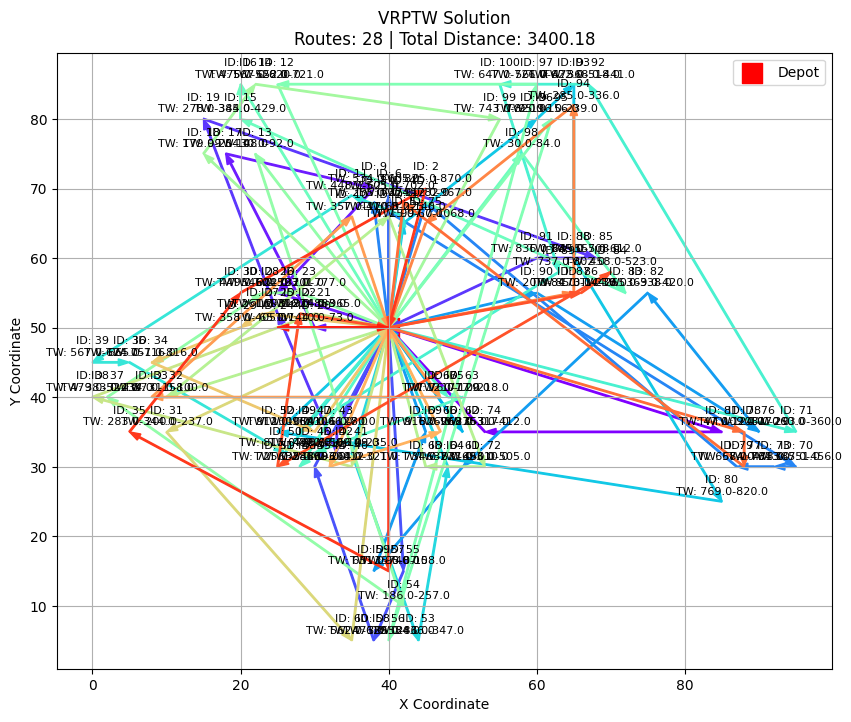

In [14]:
best_solution, best_fitness = genetic_algorithm(customers, vehicle_capacity, vehicle_speed)
print("Best Solution:", best_solution)
print("Best Fitness:", best_fitness)
plot_routes(best_solution, customers, vehicle_capacity, vehicle_speed)